# Be A Citizen Scientist - Textbook

Importo i moduli richiesti

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder


Impostazione stile dei grafici

In [71]:
plt.style.use('fast')
plt.rc('font', size = 12, family ='Sans-Serif')

In [55]:
file = '_Be a Data Scientist a #IJF19 (Responses) - Form Responses 1 (1).csv' 
df = pd.read_csv(file).replace(np.nan, 'Nessuna risposta', regex=True)

### alternativamente si possono prendere i dati direttamente dall'url..
#url_csv_file = "https://docs.google.com/spreadsheet/ccc?key=19zCRezCS3yIy6_Igzex2sotnNja2Ks57RonGX8W2R8I&output=csv"
#df = pd.read_csv(url_csv_file).replace(np.nan, 'Nessuna risposta', regex=True)

Correzione di alcuni errori nel testo di alcune domande

In [56]:
df = df.replace({'Età in anni compiuti', '75 e oltre'}, {'Età in anni compiuti', 'tra 75 e oltre'} )
from sklearn.preprocessing import OrdinalEncoder
df['young'] = np.where(df['Età in anni compiuti']<'tra 25 e 34', 1, 0)
df['Sai quali pericoli potrebbero esserci nel postare le foto sui social?']=df['Sai quali pericoli potrebbero esserci nel postare le foto sui social?'].apply(
    lambda x: 'lo so - ma non mi interessa' if x == 'lo so, ma non mi interessa' else x)
df = df.rename(columns={ 'Sul web, dove prendi le informazioni? [motori di ricerca (es google, safari, ping]': 'Sul web, dove prendi le informazioni? [motori di ricerca (es google, safari, bing)]'})
young=df[df.young==1].copy()
adults =df[df.young==0].copy()

## Funzioni per creare grafici a torta
La funzione crea un grafico a torta. Qualora l'angolo fosse troppo stretto per rendere chiaramente visibile la percentuale, viene aggiunto un piccolo tratto e la percentuale stampata esternamente al grafico per favorirne la leggibilità

In [152]:
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 7 else ''

def manage_wedges(ax, wedges):
    kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    for i, p in enumerate(wedges):
        perccc = (p.theta2 - p.theta1)/360*100
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        perc_check = (p.theta2 - p.theta1)/360*100
        if((perc_check<7) and (perc_check > 0)):
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            ax.annotate('{:1.1f}'.format(perccc)+'%', xy=(x, y), xytext=(1.3*np.sign(x), 1.3*y),
                    horizontalalignment=horizontalalignment, **kw)

In [158]:
def create_pie_chart(column, circshift=0, a=(1,), b= (1,)):

    ordinal_encoder = OrdinalEncoder()
    ordinated_encoded = ordinal_encoder.fit_transform(df[[column]]) # accetta dataframe e non serie
    ordinated_encoded_young = ordinated_encoded[df.young==1]
    ordinated_encoded_adults = ordinated_encoded[df.young==0]
    labels = np.array(ordinal_encoder.categories_[0])

    
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    fig.suptitle(column)
    fig.patch.set_facecolor('w')
    val, _ = np.histogram(ordinated_encoded, bins=len(labels))
    
    for z in zip(a,b): # a e b sono tuple
        val[z[0]],val[z[1]] = val[z[1]],val[z[0]]
    
    wedges, text, autotext = ax[0].pie(np.roll(np.flip(val), circshift), autopct=my_autopct, pctdistance = 0.65)
    ax[0].set_title('All')
    manage_wedges(ax[0],wedges)


    val, _ = np.histogram(ordinated_encoded_young, bins=len(labels))
    for z in zip(a,b): # a e b sono tuple
        val[z[0]],val[z[1]] = val[z[1]],val[z[0]]
    
    wedges, text, autotext = ax[1].pie(np.roll(np.flip(val), circshift), autopct=my_autopct, pctdistance = 0.65)
    ax[1].set_title('Young')
    manage_wedges(ax[1],wedges)

    val, _ = np.histogram(ordinated_encoded_adults, bins=len(labels))
    for z in zip(a,b): # a e b sono tuple
        val[z[0]],val[z[1]] = val[z[1]],val[z[0]]
    #val[a], val[b] = val[b], val[a]
    wedges, text, autotext = ax[2].pie(np.roll(np.flip(val), circshift), autopct=my_autopct, pctdistance = 0.65)
    ax[2].set_title('Adults')
    manage_wedges(ax[2],wedges)

    labels = [x.capitalize() for x in labels]
    
    columns = len(wedges)
    
    for z in zip(a,b): # a e b sono tuple
        labels[z[0]],labels[z[1]] = labels[z[1]],labels[z[0]]
    fig.legend(wedges, np.roll(np.flip(labels),circshift), title = '', loc = 'lower center', ncol = int(np.ceil(columns/2)))

    return 
    # scambi di posizioni, inversioni e permutazioni circolari possono essere sfruttate per migliorare le leggiblità del grafico

## Funzioni per realizzare istogrammi
- La funzione multiple_choice estrae i valori da graficare.
- La funzione create_histogram permette di creare istogrammi raggruppati, ovvero graficare risposte con gli stessi valori a domande diverse (vedere esempio)
- La funzione create_single_historam produce un istogramma di una particolare domanda

In [59]:
def multiple_choice(question, db):
  multiple_answar = db[question].str.split(',\s*').apply(lambda x: pd.Series(1,index=x)).fillna(0)
  labels=[]
  values=[]
  for i in range (0, len(multiple_answar.columns)):
    labels.append(multiple_answar.columns[i])
    values.append(multiple_answar[multiple_answar.columns[i]].sum())
  return values, labels

In [162]:
def create_histograms(questions):
    cols = 2
    rows = int(np.ceil(len(questions)/cols))
    if(not np.mod(rows,2)): 
        rows = int(np.ceil(len(questions)/cols))
    fig, ax = plt.subplots(rows, cols , sharex=True, sharey = True, figsize = (10,2*rows))
    fig.patch.set_facecolor('w')
    plt.subplots_adjust(hspace =0,wspace =0.05)

    for k, column in enumerate(questions):
        values,labels = multiple_choice(question=column, db=df)
        values_y,labels_y = multiple_choice(question=column, db=young)
        values_o,labels_o = multiple_choice(question=column, db=adults)
        # valori in percentule
        values   = np.array(values) * 100./len(df)
        values_y = np.array(values_y) * 100./len(young)
        values_o = np.array(values_o) * 100./len(adults)
        #
        all_labels = labels + labels_y + labels_o
        all_labels = list(set(all_labels))
        all_values=np.zeros(len(labels))
        all_values_y=np.zeros(len(all_labels))
        all_values_o=np.zeros(len(all_labels))
        for i in range(0, len(all_labels)):
          if all_labels[i] in labels:
            all_values[i] = values[labels.index(all_labels[i])]
          if all_labels[i] in labels_y:
            all_values_y[i] = values_y[labels_y.index(all_labels[i])]
          if all_labels[i] in labels_o:
            all_values_o[i] = values_o[labels_o.index(all_labels[i])]

        all_labels = [x.capitalize() for x in all_labels]

        x = np.linspace(-3,len(all_labels),len(all_labels))-0.5
        ax.flat[k].bar(x-0.3, np.array(all_values), width=0.3, label='All')
        ax.flat[k].bar(x, np.array(all_values_y), width=0.3, color='red', label='Young')
        ax.flat[k].bar(x+0.3, np.array(all_values_o), width=0.3, color='green', label='Adults')
        ax.flat[k].set_xticks(x)
        ax.flat[k].set_xticklabels(all_labels, rotation=90)
        ax.flat[k].set_ylim((0,85))

        if(np.mod(k,2)):
            ax.flat[k].yaxis.tick_right()

        try:
            ax.flat[k].set_title(column[column.find("[")+1:column.find("]")], {'fontsize':10},pad = -15)
        except:
            ax.flat[k].set_title(column, {'fontsize':10},pad = -15)
    #    ax.flat[k].set_ylabel('percentage [%]')
        #ax.legend()

    handles, labels = ax.flat[k].get_legend_handles_labels()

    if rows*cols> len(questions):
        k+=1
        ax.flat[k].set_xticks(x)
        ax.flat[k].set_xticklabels(all_labels, rotation=90)

        ax.flat[k].legend(handles, labels, loc='center', ncol = 3)
    else:
        fig.legend(handles, labels, title = '', loc = 'lower center', ncol = 3)

    fig.text(0.05, 0.5, 'Percentage [%]', va='center', rotation='vertical');

In [165]:
def create_single_histogram(column):

#    fig, ax = plt.subplots()
    values,labels = multiple_choice(question=column, db=df)
    values_y,labels_y = multiple_choice(question=column, db=young)
    values_o,labels_o = multiple_choice(question=column, db=adults)
    # valori in percentule
    values   = np.array(values) * 100./len(df)
    values_y = np.array(values_y) * 100./len(young)
    values_o = np.array(values_o) * 100./len(adults)
    #
    all_labels = labels + labels_y + labels_o
    all_labels = list(set(all_labels))
    all_values=np.zeros(len(labels))
    all_values_y=np.zeros(len(all_labels))
    all_values_o=np.zeros(len(all_labels))
    for i in range(0, len(all_labels)):
      if all_labels[i] in labels:
        all_values[i] = values[labels.index(all_labels[i])]
      if all_labels[i] in labels_y:
        all_values_y[i] = values_y[labels_y.index(all_labels[i])]
      if all_labels[i] in labels_o:
        all_values_o[i] = values_o[labels_o.index(all_labels[i])]

    all_labels = [x.capitalize() for x in all_labels]
    
    x = np.linspace(0,len(all_labels),len(all_labels))
    plt.bar(x-0.3, np.array(all_values), width=0.3, label='all')
    plt.bar(x, np.array(all_values_y), width=0.3, color='red', label='young')
    plt.bar(x+0.3, np.array(all_values_o), width=0.3, color='green', label='adults')
    plt.xticks(x, all_labels, rotation='vertical')
    plt.ylabel('Percentage [%]')
    plt.title(column)
    plt.legend()
    fig = plt.gcf()
    fig.patch.set_facecolor('w')


# Risposte ad alcune domande interessanti

## Attitudine all'informazione

Questi grafici riporta la frequenza con cui i soggetti si informano in generale ed in particolare su argomenti scientifici. La rappresentazione è divisa tra adulti giovani e campione unito.

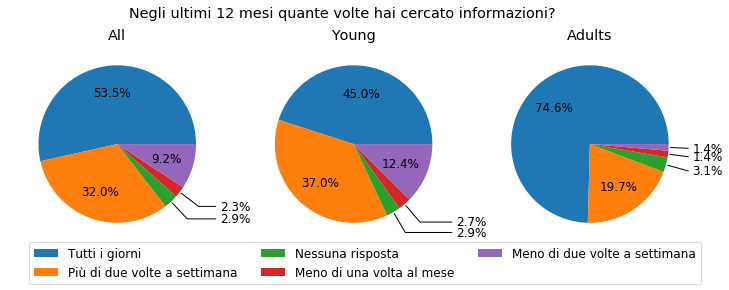

In [159]:
create_pie_chart('Negli ultimi 12 mesi quante volte hai cercato informazioni?')

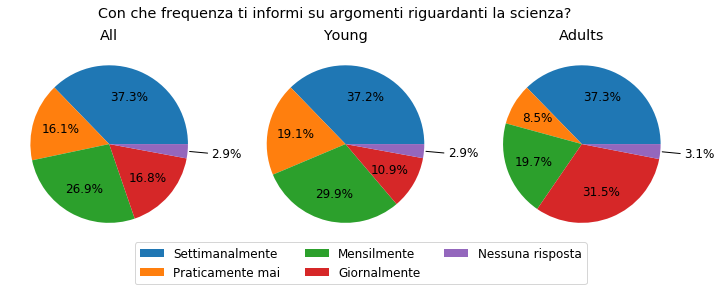

In [161]:
create_pie_chart('Con che frequenza ti informi su argomenti riguardanti la scienza?')

# Dove si raccolgono informazioni sul web?

## Sorgenti di informazione

Questo istogramma multiplo permette di comparare visivamente come il campione attinge alle diverse fonti di informazione presenti sulla rete. L'asse x è comune a tutti i frames, l'asse y riporta la percentuale.

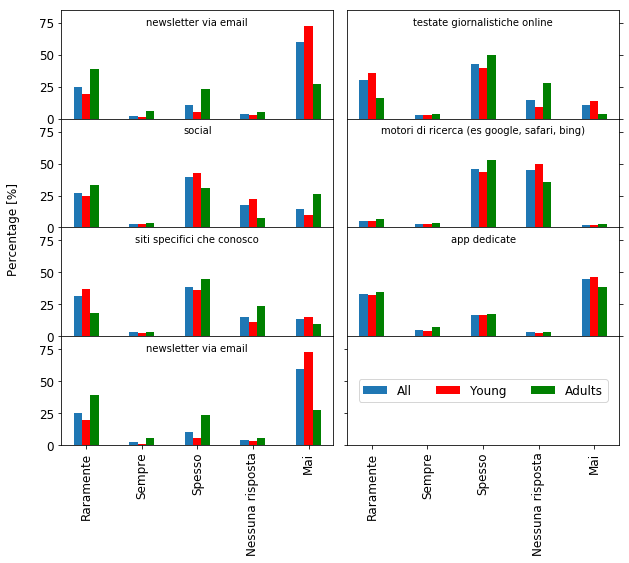

In [164]:
questions = ['Sul web, dove prendi le informazioni? [newsletter via email]','Sul web, dove prendi le informazioni? [testate giornalistiche online]','Sul web, dove prendi le informazioni? [social]','Sul web, dove prendi le informazioni? [motori di ricerca (es google, safari, bing)]','Sul web, dove prendi le informazioni? [siti specifici che conosco]','Sul web, dove prendi le informazioni? [app dedicate]','Sul web, dove prendi le informazioni? [newsletter via email]']
create_histograms(questions)



### Social network come fonti d'informazione

Questi grafici a torta permettono di visualizzare più nel dettaglio verso quali social si indirizzano gli interessi degli utenti, e quali aspetti richiamano maggiornmente la loro attenzione.

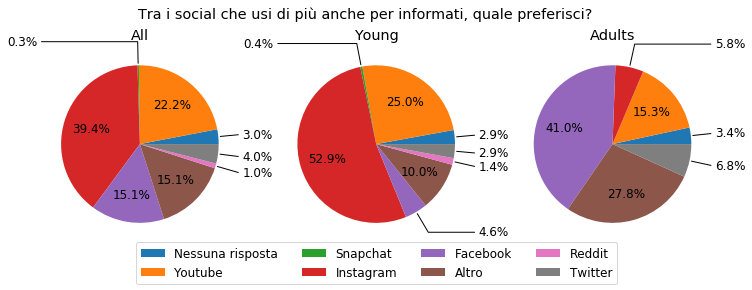

In [166]:
create_pie_chart('Tra i social che usi di più anche per informati, quale preferisci?',circshift=6, a= (7,5),b=(4,3))

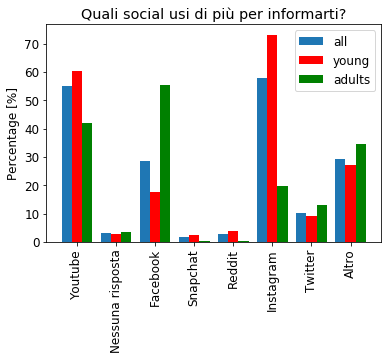

In [167]:
create_single_histogram('Quali social usi di più per informarti?')

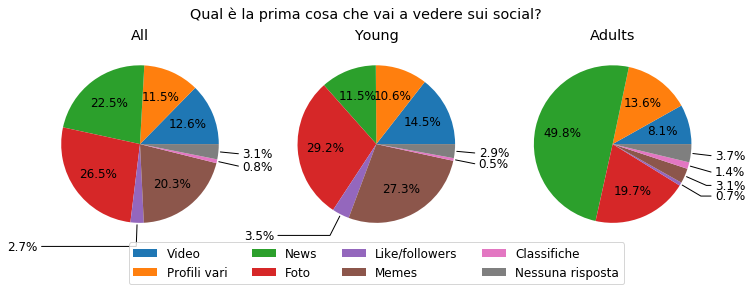

In [170]:
create_pie_chart('Qual è la prima cosa che vai a vedere sui social?', circshift=0, a=(2,), b = (4,))